In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"
}

In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Use only singlets

In [6]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 36 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 


Saving 6.67 x 6.67 in image


Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 


Saving 6.67 x 6.67 in image


Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_3 


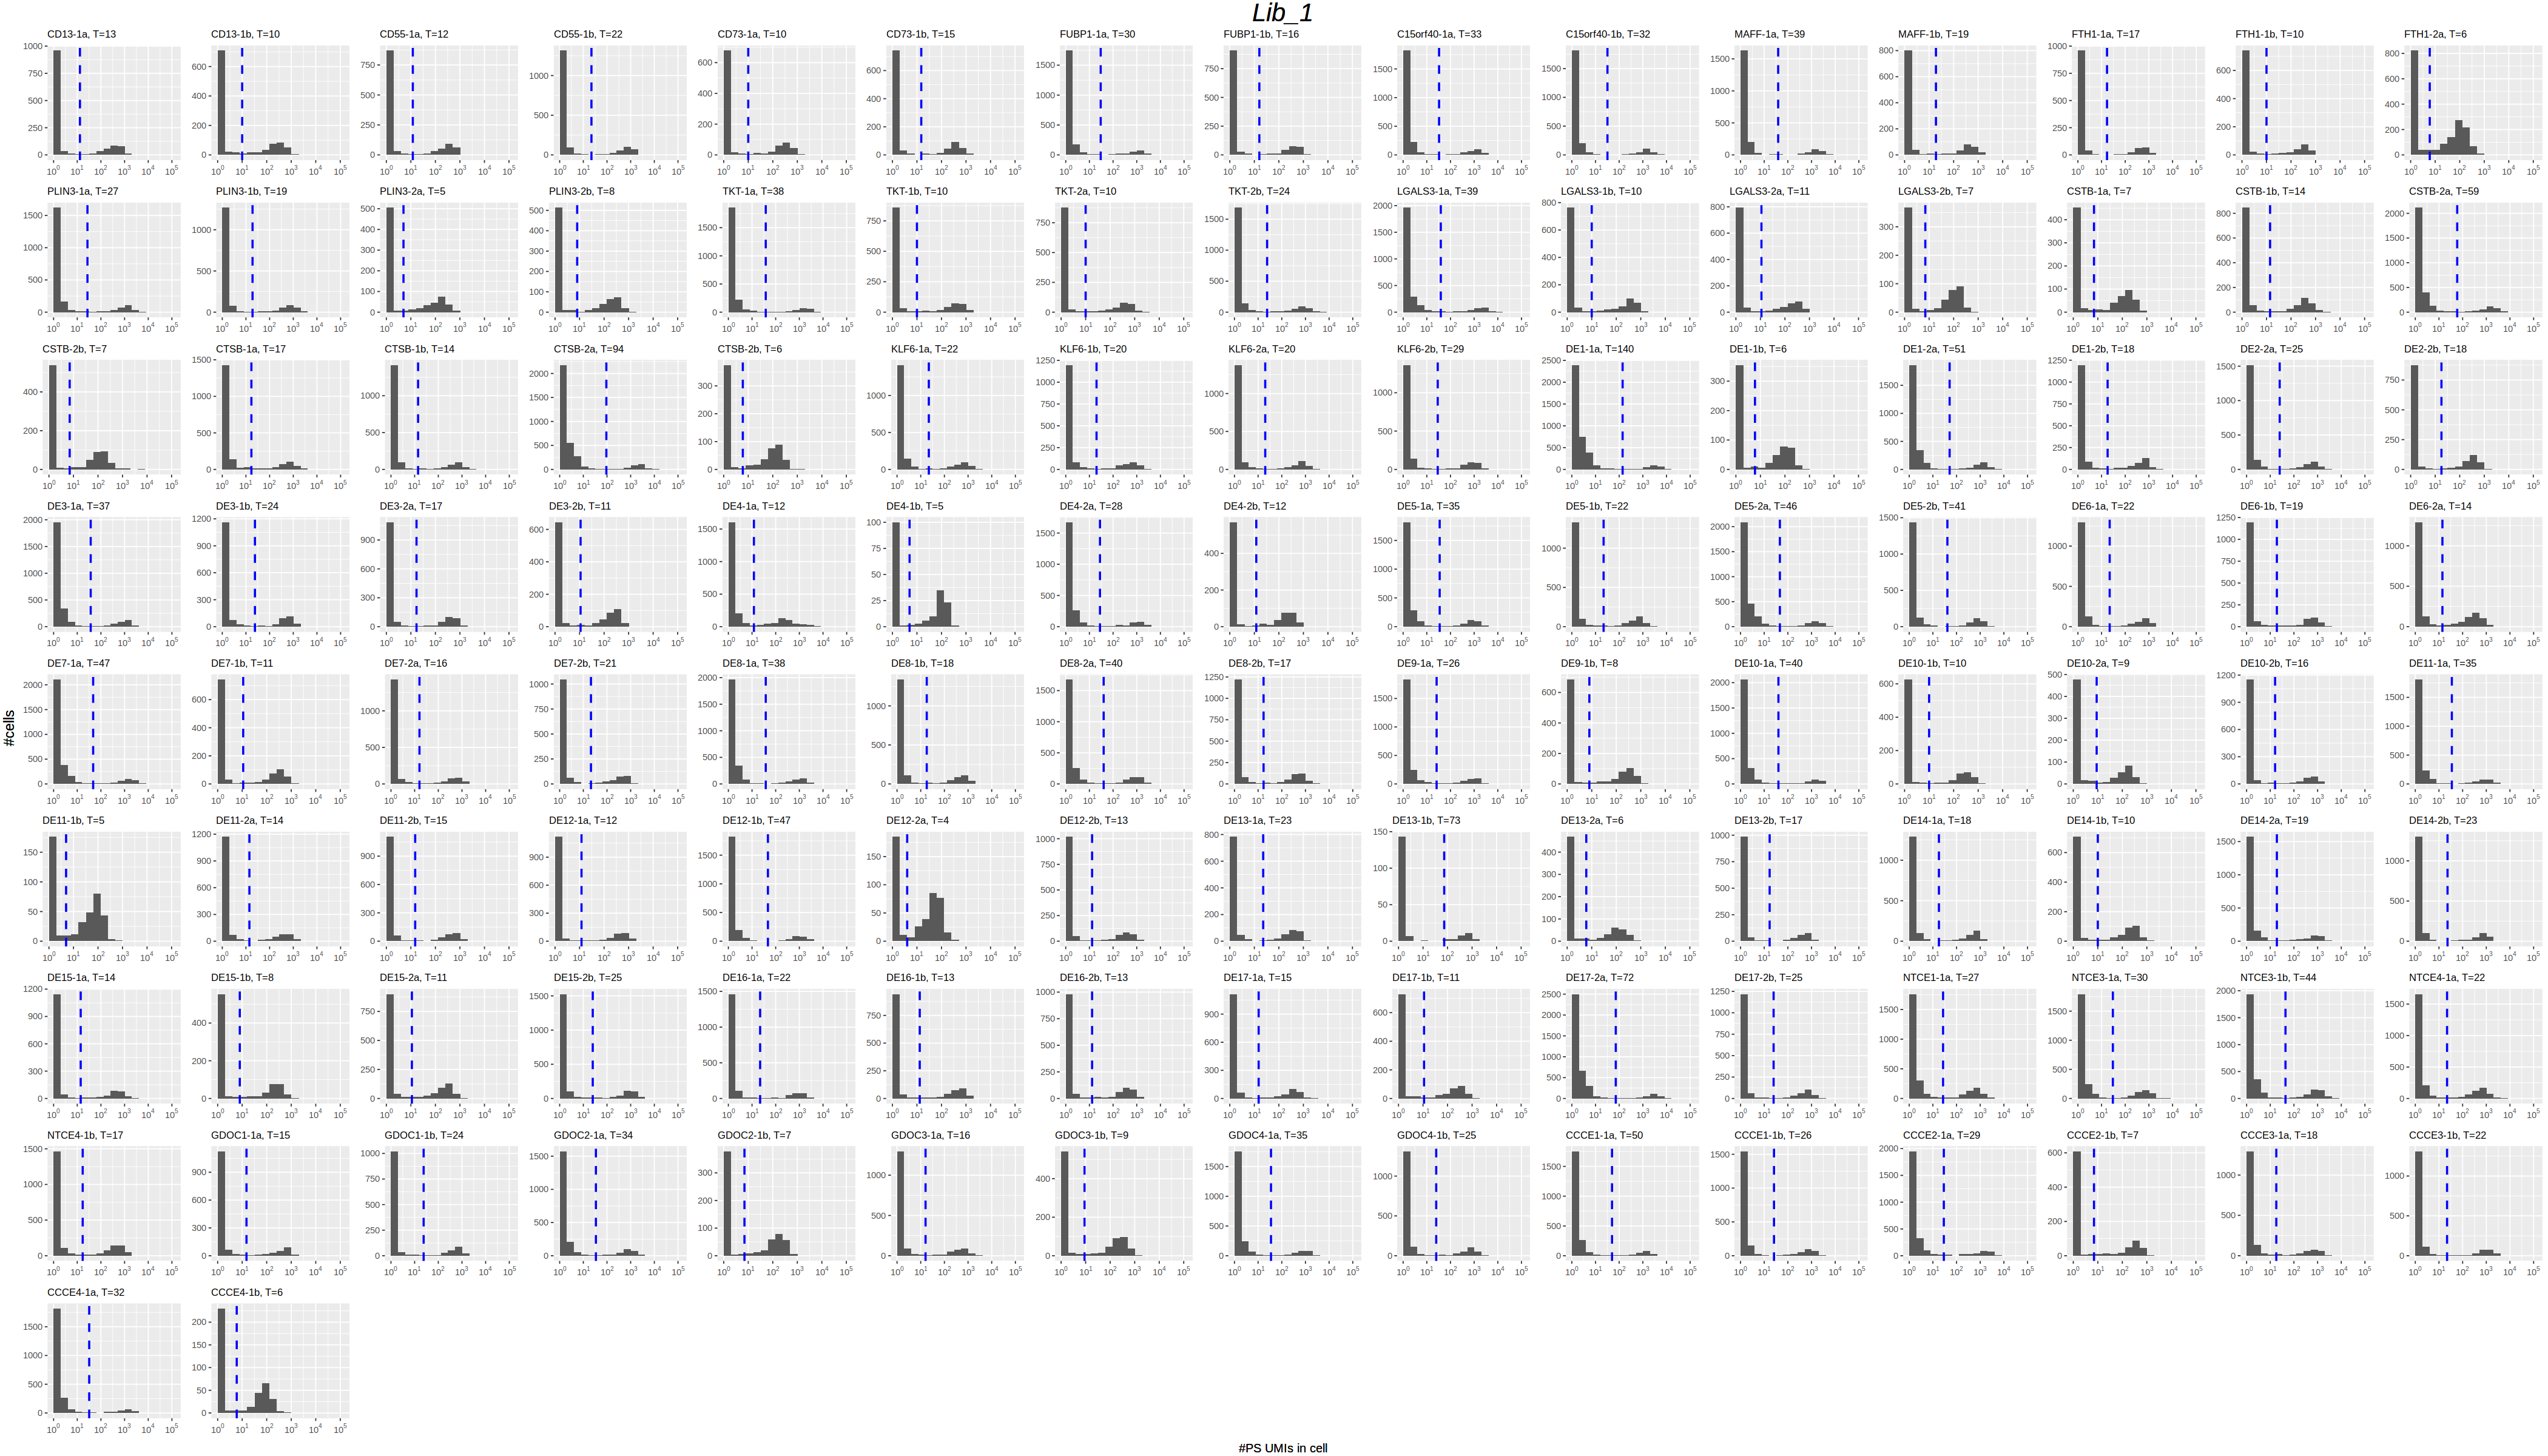

Saving 6.67 x 6.67 in image


Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 2 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


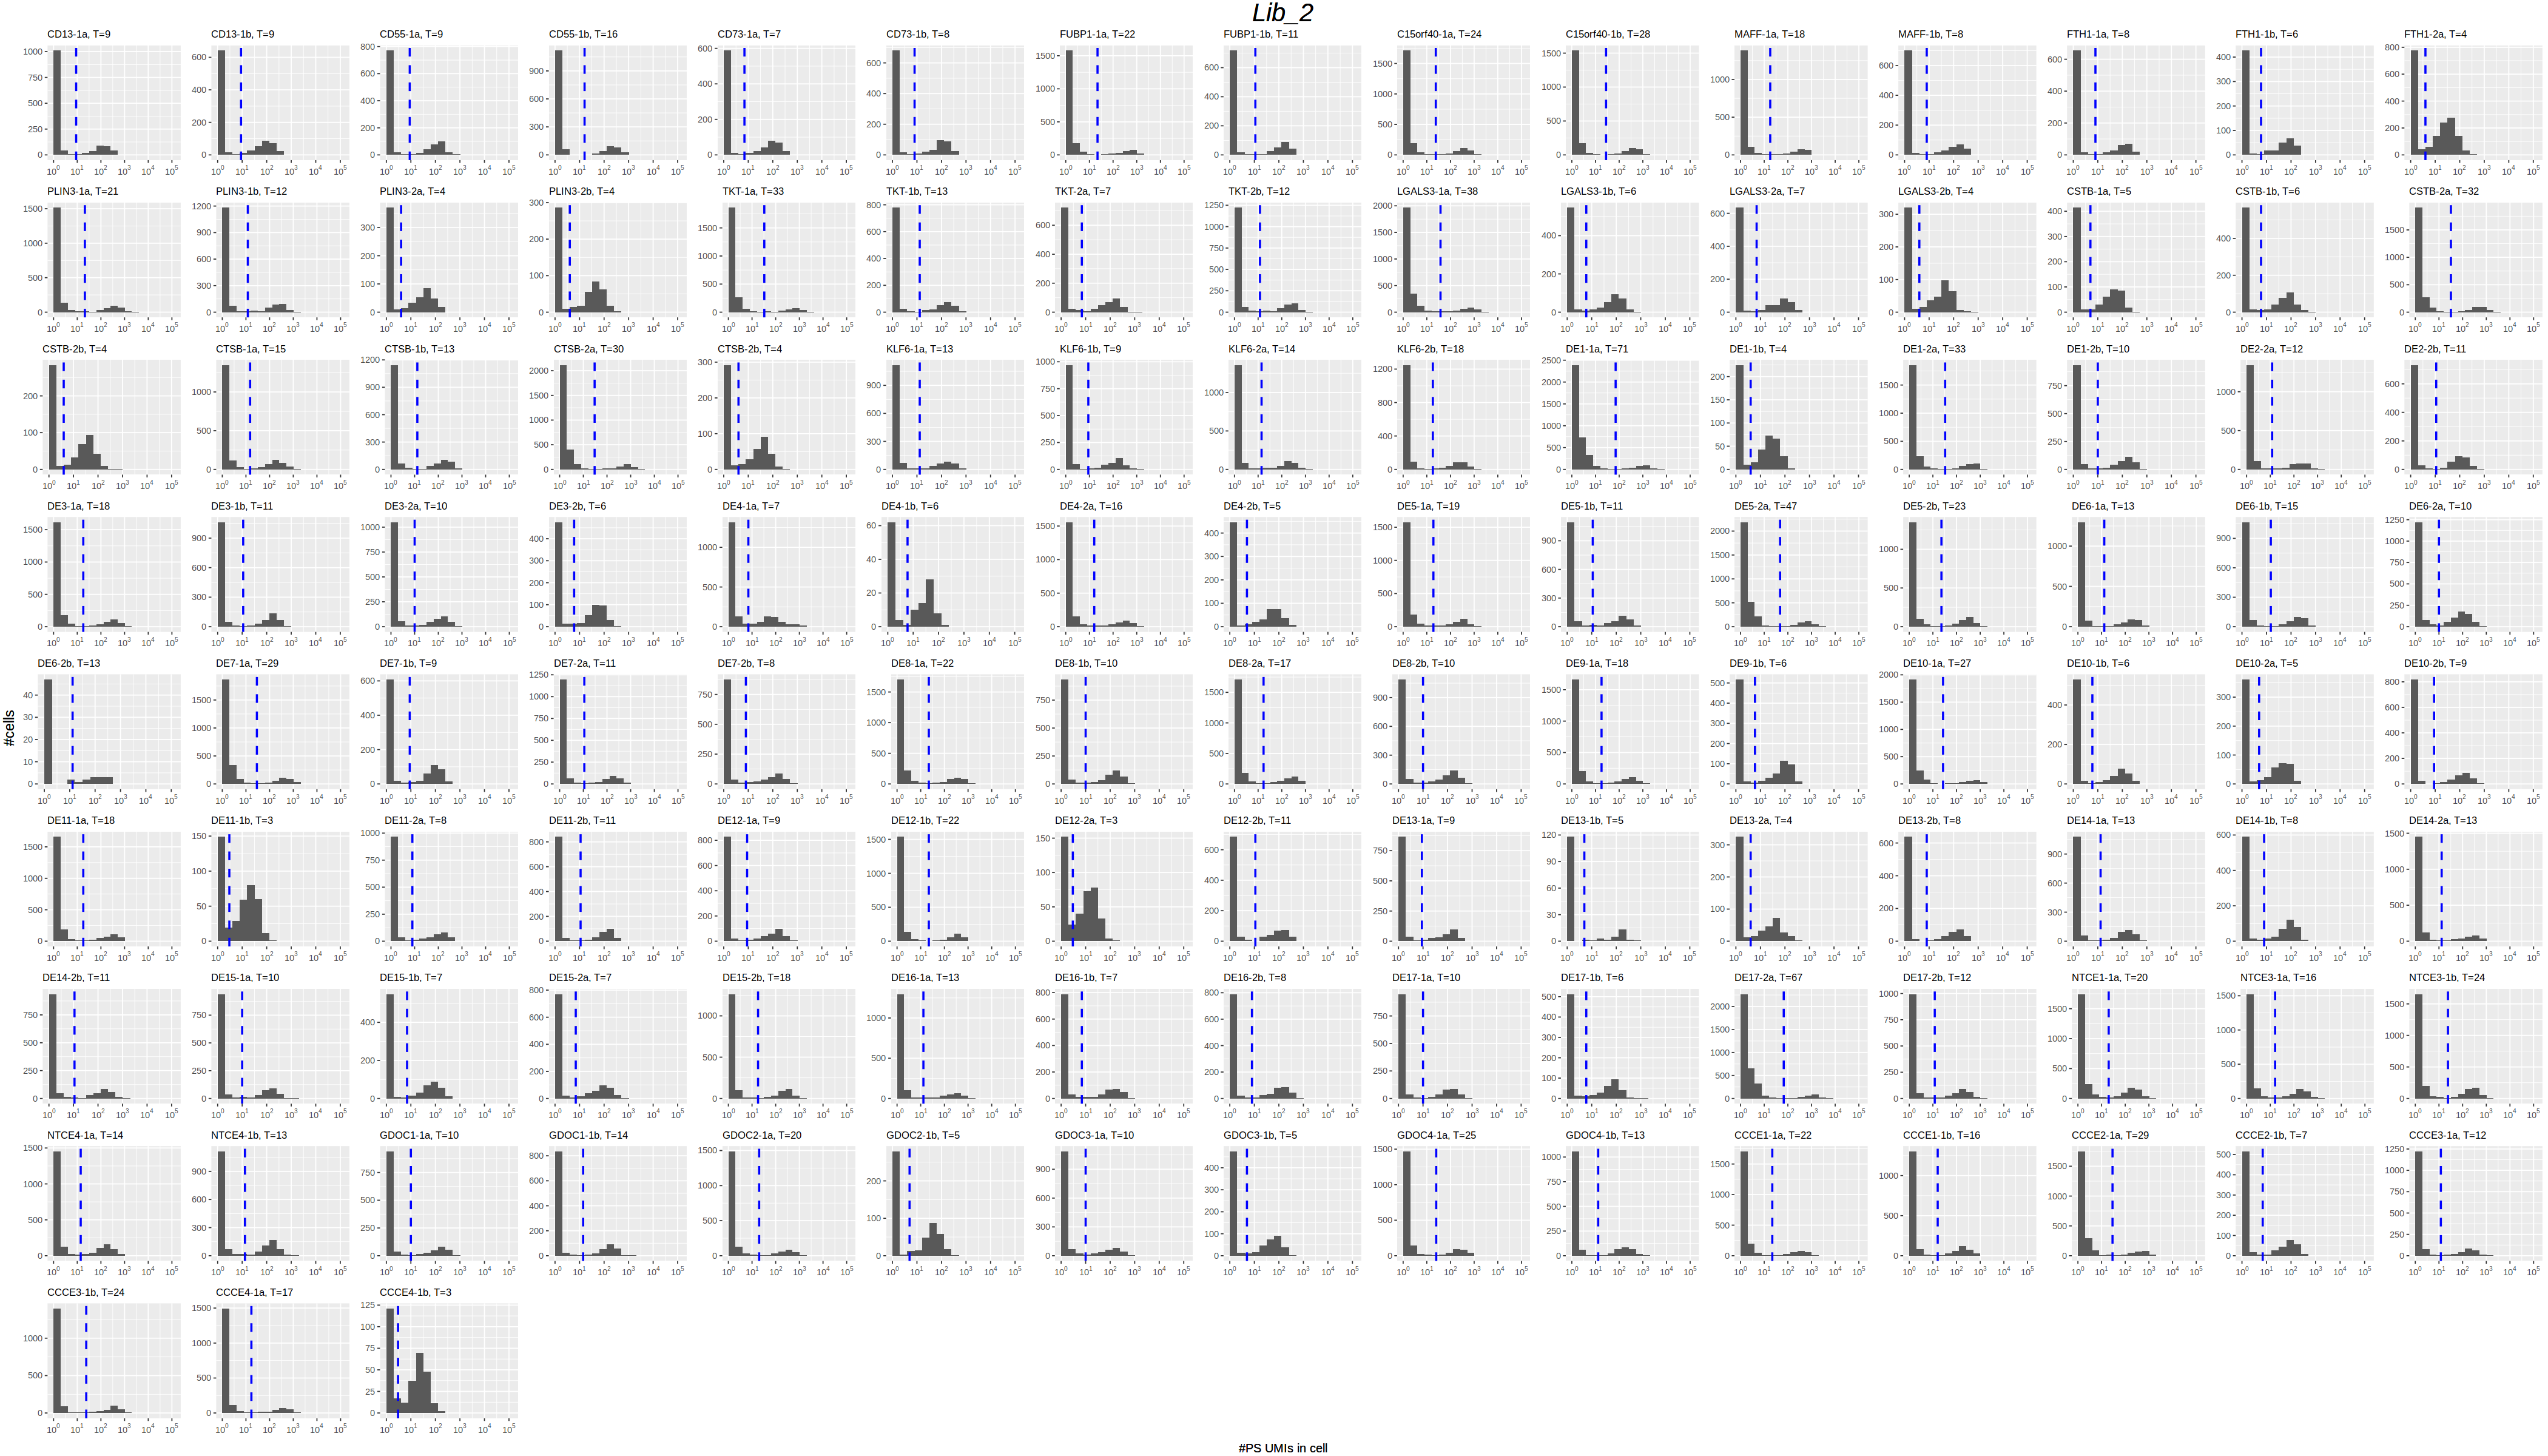

Saving 6.67 x 6.67 in image


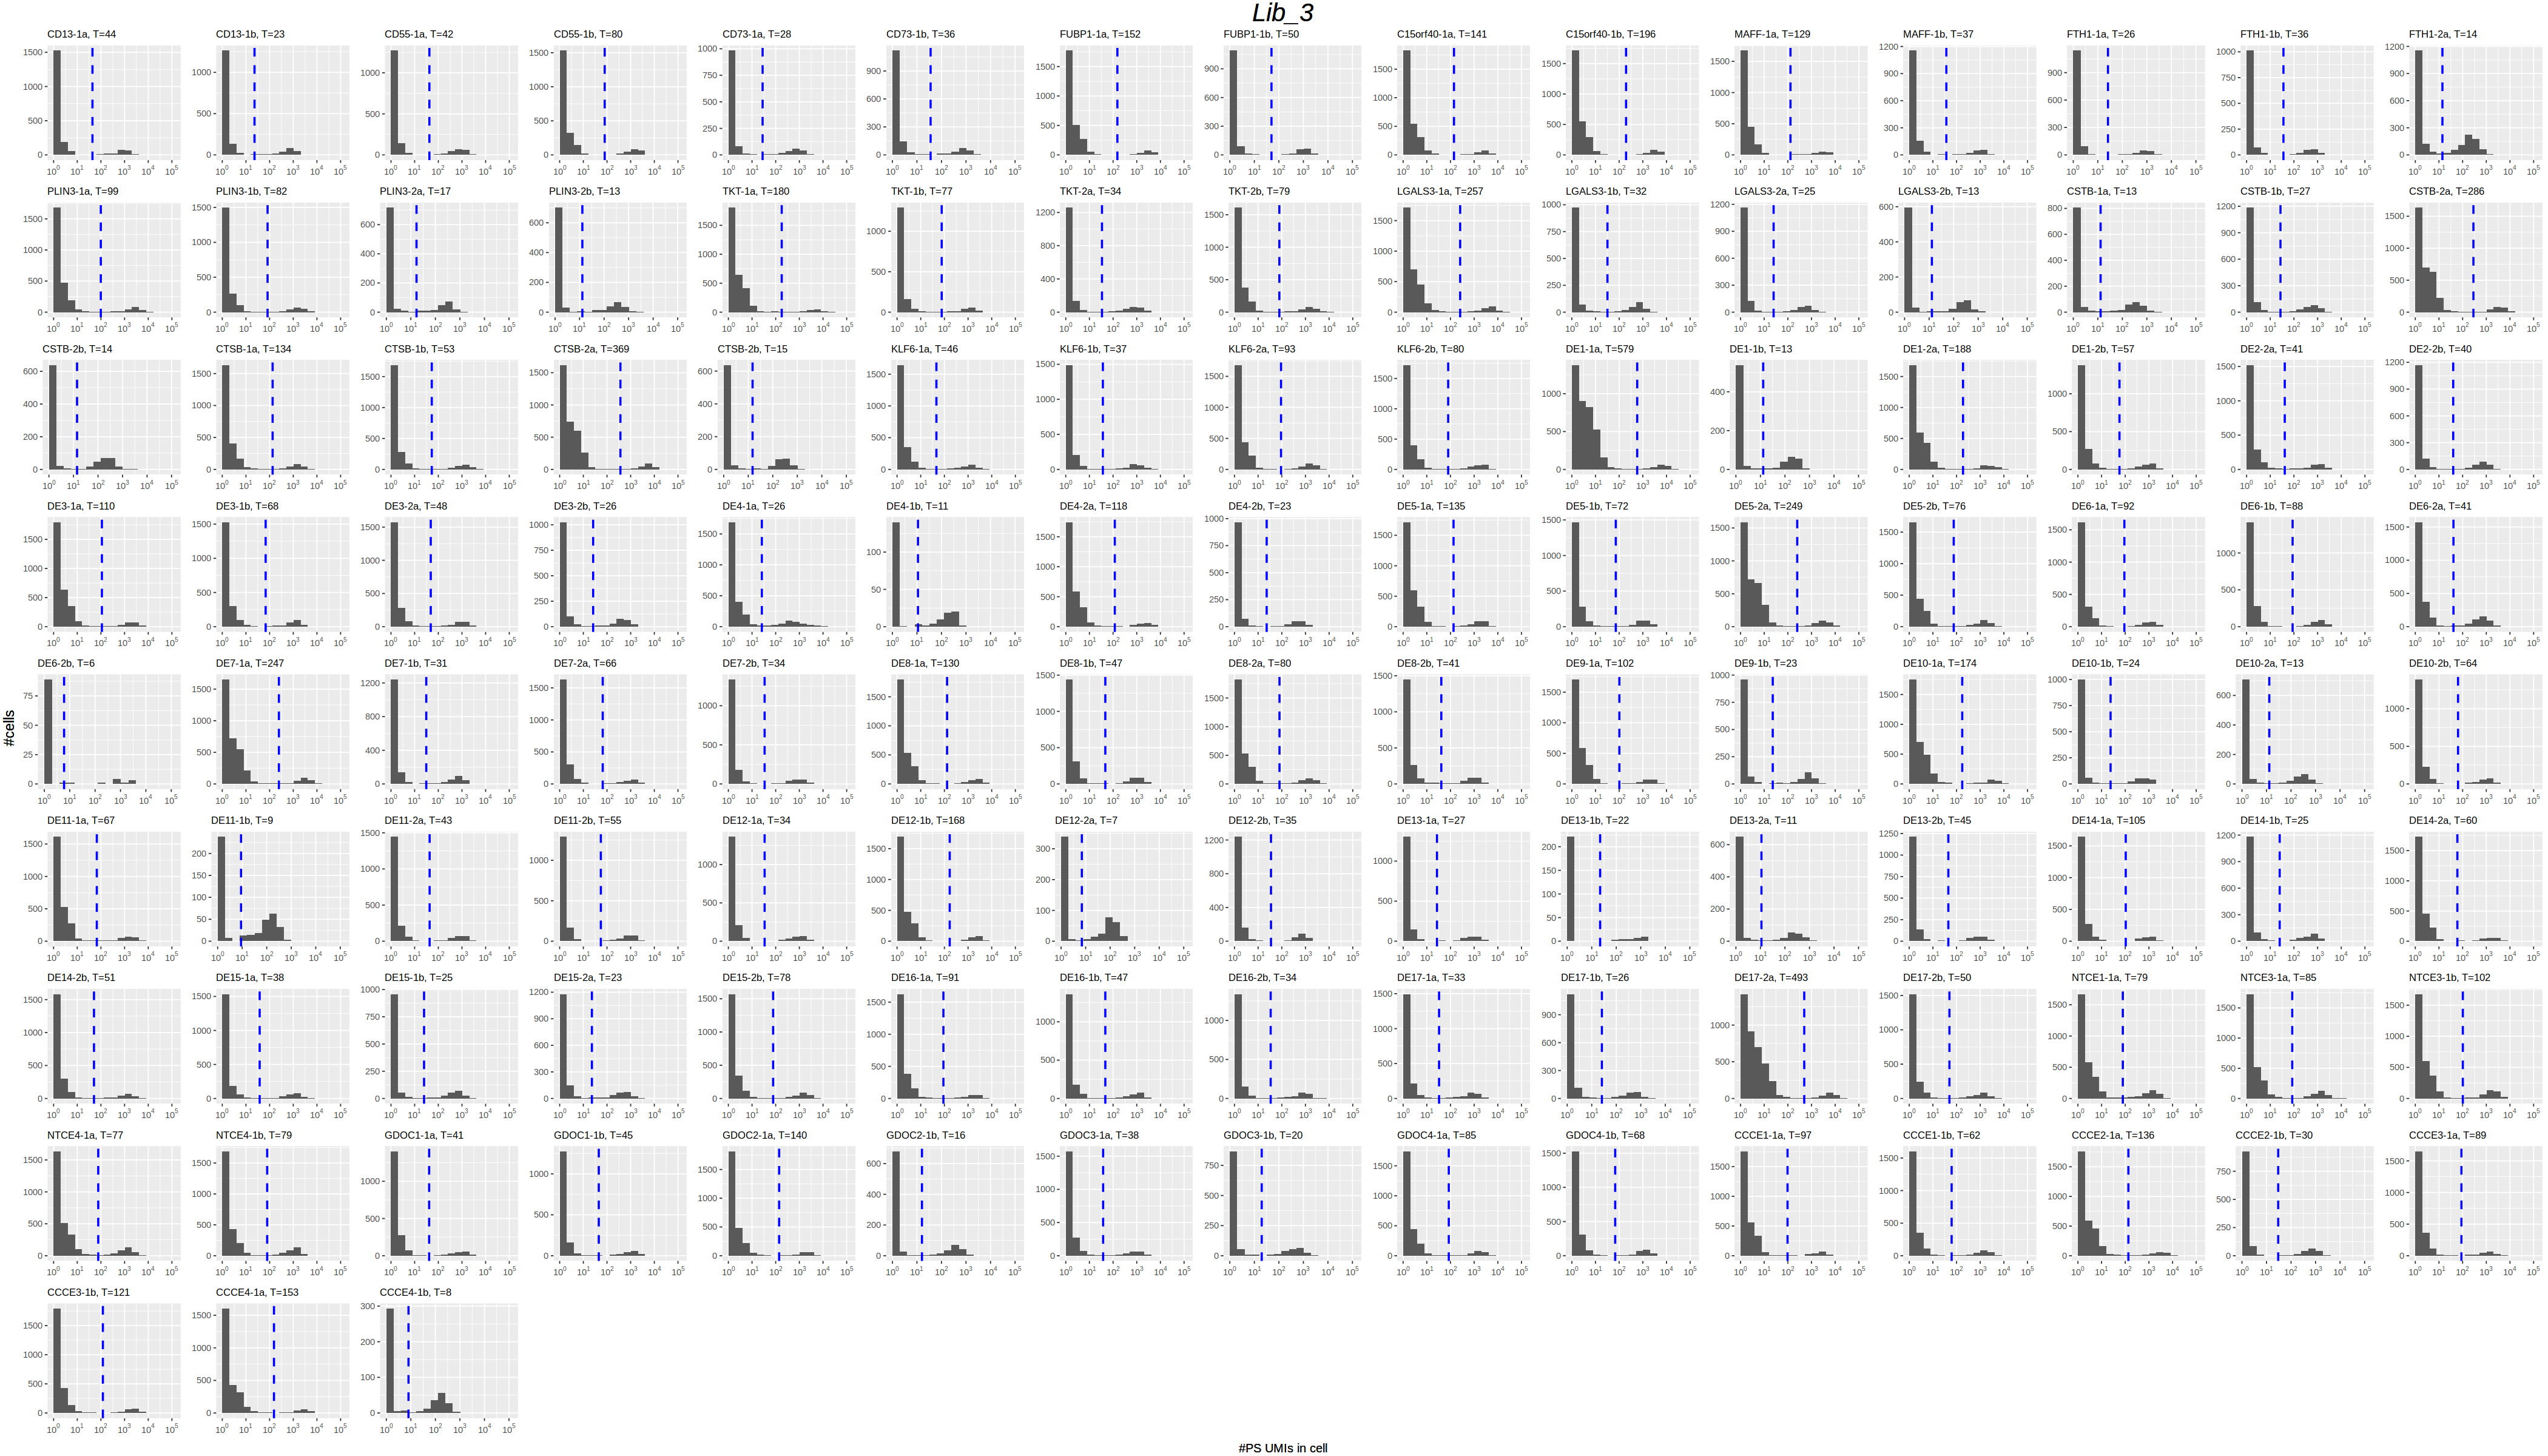

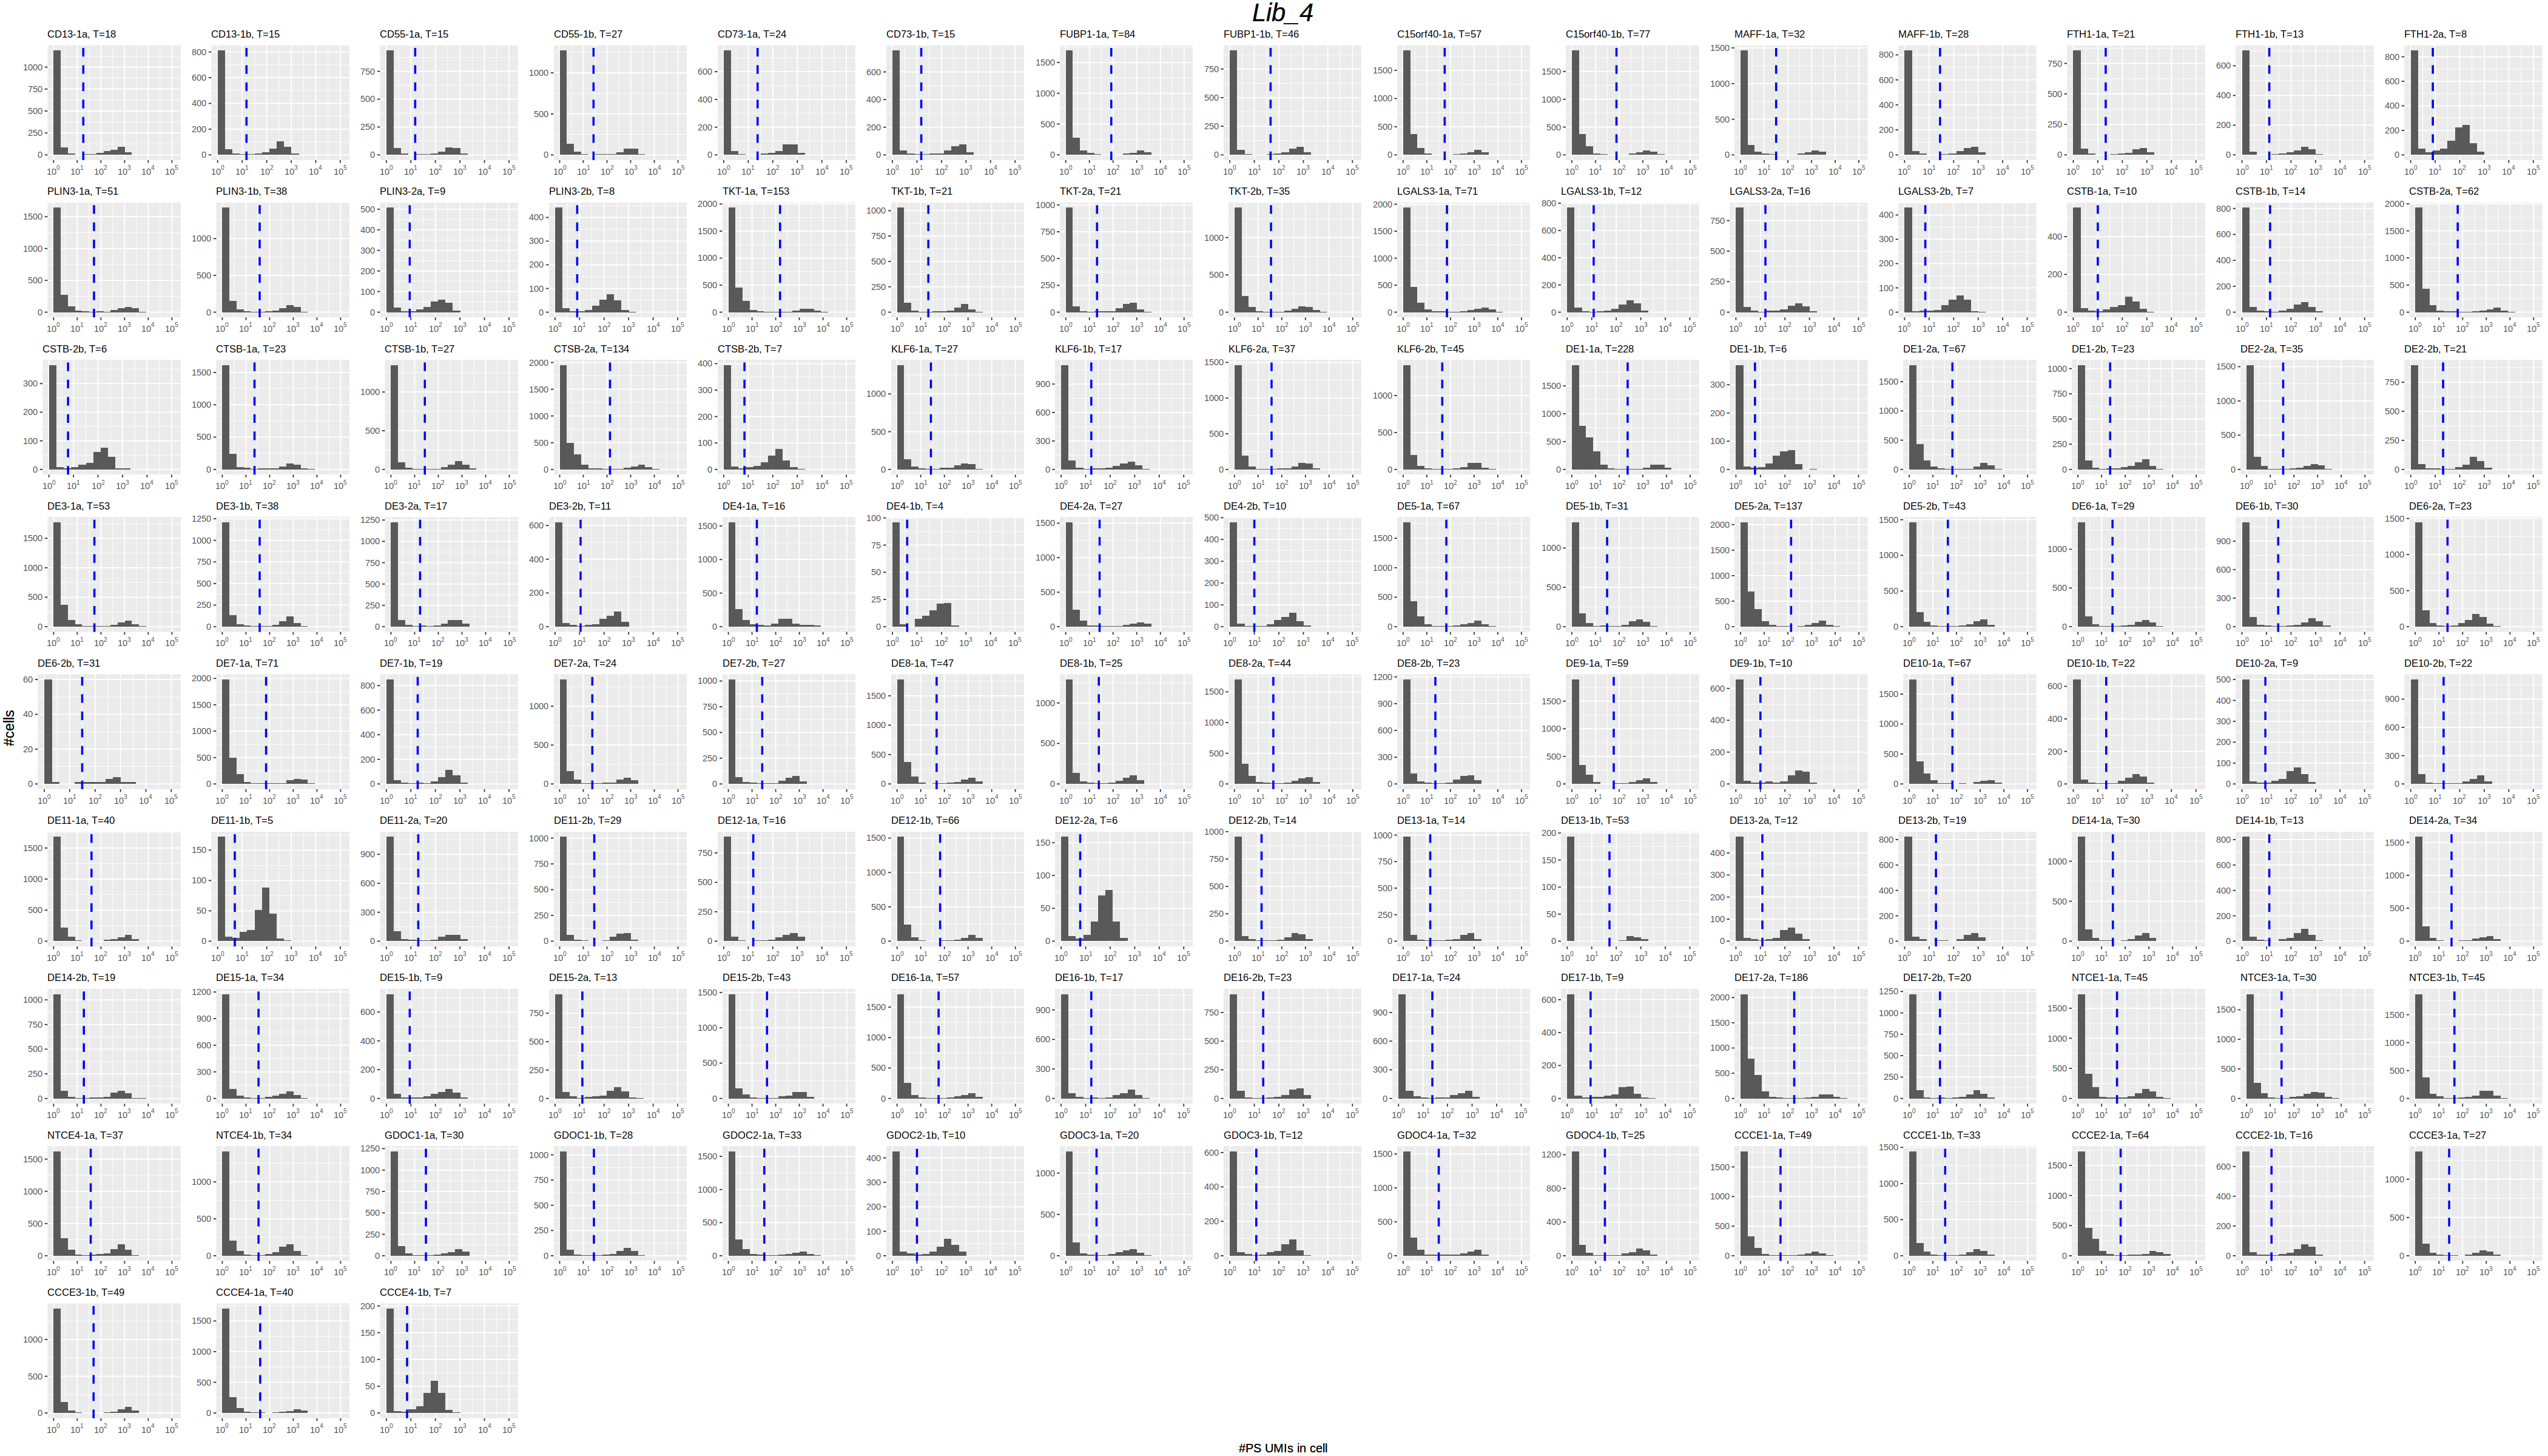

In [15]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"), 
        plt,
        width = 22, 
        height = 17, 
        dpi = 300
    )
}

# Write thresholds to file

In [16]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)
write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15


In [17]:
df_thresholds

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15
7,Lib_1,FUBP1-1a,30
8,Lib_1,FUBP1-1b,16
9,Lib_1,C15orf40-1a,33
